## Import data

In [1]:
# Install gdown to download from Google Drive
!pip install gdown
import gdown
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#use this to directly load the a comment-summary data set from its gdrive link


def load_data_from_gdrive(file_id):
  #formulate download_url
  download_url = f"https://drive.google.com/uc?id={file_id}"

  # Download the file
  gdown.download(download_url, 'global_inputs.json', quiet=False)

  # Load the data from the downloaded file
  with open('global_inputs.json', 'r') as f:
      loaded_data = json.load(f)
  return loaded_data



In [11]:
#load the data
file_id = "1nwboe43hoofvdvTNbFr8PJ_-OVgHlnpn"
loaded_data = load_data_from_gdrive(file_id)

Downloading...
From: https://drive.google.com/uc?id=1nwboe43hoofvdvTNbFr8PJ_-OVgHlnpn
To: /content/global_inputs.json
100%|██████████| 47.5k/47.5k [00:00<00:00, 46.5MB/s]


## Get the core data we need into data frames

In [3]:
#get the minimum data we need from the loaded summary


def extract_to_dataframes(loaded_data):
  #get the comment data
  commentData = []
  for i in range(0,len(loaded_data['inputCommentsJson']['polis-comments']['children'])):
    cmnt = loaded_data['inputCommentsJson']['polis-comments']['children'][i]['comment']['children'][0]['text']['content']
    cid = loaded_data['inputCommentsJson']['polis-comments']['children'][i]['comment']['id']
    commentData.append([cid,cmnt])
  commentDataDF = pd.DataFrame(commentData, columns=['cid','text'])


  #get the clauses data
  modelResponse = json.loads(loaded_data['modelResponse'])
  clauses = []
  for p in range(0,len(modelResponse['paragraphs'])):
    paragraph = modelResponse['paragraphs'][p]
    for s in range(0,len(paragraph['sentences'])):
      sentence = paragraph['sentences'][s]
      for c in range(0,len(sentence['clauses'])):
        clause = sentence['clauses'][c]['text']
        citations = sentence['clauses'][c]['citations']
        clauses.append([clause,citations])
  clausesDF = pd.DataFrame(clauses, columns=['text','citations'])
  return commentDataDF, clausesDF

# comments, clauses  = extract_to_dataframes(loaded_data)

In [12]:
comments, clauses  = extract_to_dataframes(loaded_data)

## add text embeddings for clauses and comments


In [9]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
import numpy as np
import random

# ----------------------------------
# function to generate generate 1024 dimension embeddinggs using text-embedding-3-small model
def get_embedding(text):
   text = text.replace("\n", " ")
   return model.encode(text)
# ----------------------------------


# ----------------------------------
# function to add embeddings to the 'text' row qs data frame
def embed_text_row(row):
  text = row["text"]
  return get_embedding(text)
# ----------------------------------


# ----------------------------------
# function to add embeddings for all 'text' values in a qs data frame
def embed_df_text(df):
  #print("begin")
  df["embedding"] = df.apply (lambda row: embed_text_row(row), axis=1)
  return df
# ----------------------------------


In [13]:
# add the embeddings to teh clauses and comments
comments = embed_df_text(comments)
clauses = embed_df_text(clauses)

## compute the semantic simliarity between clauses and comments and use to compute coverage


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(comments_df, clauses_df, threshold=0.7):
    """
    Compute semantic similarity between each comment and clause.

    Parameters:
    -----------
    comments_df : pandas DataFrame
        DataFrame containing comments with 'text' and 'embedding' columns
    clauses_df : pandas DataFrame
        DataFrame containing clauses with 'text' and 'embedding' columns
    threshold : float, default=0.7
        Threshold value for determining if similarity is high enough

    Returns:
    --------
    similarity_matrix : numpy array
        Matrix where [i,j] contains the semantic similarity between
        comment i and clause j, with additional columns for:
        - MAX value of each row
        - Binary indicator (1/0) if MAX > threshold
    """
    # Get embeddings from dataframes
    comment_embeddings = np.vstack(comments_df['embedding'].values)
    clause_embeddings = np.vstack(clauses_df['embedding'].values)

    # Compute cosine similarity between all comment and clause pairs
    base_similarity_matrix = cosine_similarity(comment_embeddings, clause_embeddings)

    # Calculate the maximum similarity for each comment (row)
    max_similarity = np.max(base_similarity_matrix, axis=1).reshape(-1, 1)

    # Create threshold column (1 if MAX > threshold, 0 otherwise)
    threshold_column = (max_similarity > threshold).astype(float)

    # Append the max and threshold columns to the similarity matrix
    similarity_matrix = np.hstack((base_similarity_matrix, max_similarity, threshold_column))

    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, comments_df, clauses_df, figsize=(14, 10),
                            fontsize=8, cmap='Blues', title='Comment-Clause Semantic Similarity',
                            threshold=0.7):
    """
    Generate a heatmap visualization of semantic similarities between comments and clauses.

    Parameters:
    -----------
    similarity_matrix : numpy array
        Matrix where [i,j] contains the semantic similarity between comment i and clause j,
        with additional columns for MAX similarity and threshold indicator
    comments_df : pandas DataFrame
        DataFrame containing comments with 'text' column
    clauses_df : pandas DataFrame
        DataFrame containing clauses with 'text' column
    figsize : tuple
        Figure size (width, height) in inches
    fontsize : int
        Font size for text labels
    cmap : str
        Colormap name (using 'Blues' for white to dark blue)
    title : str
        Title for the heatmap
    threshold : float, default=0.7
        Threshold value used for the binary column (shown in title)

    Returns:
    --------
    fig : matplotlib Figure
        The generated figure object
    ax : matplotlib Axes
        The generated axes object
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Get text labels
    comment_texts = comments_df['text'].values
    clause_texts = clauses_df['text'].values

    # Truncate long texts for readability
    max_text_length = 50
    comment_labels = [text[:max_text_length] + "..." if len(text) > max_text_length else text
                      for text in comment_texts]
    clause_labels = [text[:max_text_length] + "..." if len(text) > max_text_length else text
                     for text in clause_texts]

    # Add special column labels
    all_x_labels = clause_labels + ["MAX", f"Over Similarity\nThreshold ({threshold})"]

    # Plot heatmap
    sns.heatmap(similarity_matrix, annot=False, cmap=cmap, vmin=0, vmax=1,
                xticklabels=all_x_labels, yticklabels=comment_labels, ax=ax)

    # Customize plot
    ax.set_title(title, fontsize=fontsize+4)
    ax.set_xlabel('Clauses', fontsize=fontsize+2)
    ax.set_ylabel('Comments', fontsize=fontsize+2)

    # Adjust font size and rotation for better readability
    plt.xticks(rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)

    # Highlight the special columns
    ax.axvline(x=len(clause_texts), color='black', linestyle='-', linewidth=1)
    ax.axvline(x=len(clause_texts)+1, color='black', linestyle='-', linewidth=1)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

def calculate_percentage_above_threshold(similarity_matrix, threshold):
    """
    Calculate the percentage of comments with maximum similarity above a given threshold.

    Parameters:
    -----------
    similarity_matrix : numpy array
        The full similarity matrix with MAX column as the second-to-last column
    threshold : float
        The similarity threshold to check against

    Returns:
    --------
    percentage : float
        Percentage of comments with max similarity above the threshold
    count : int
        Number of comments with max similarity above the threshold
    total : int
        Total number of comments
    """
    # Extract the MAX column (second-to-last column)
    max_column = similarity_matrix[:, -2]

    # Count comments above threshold
    count_above_threshold = np.sum(max_column > threshold)

    # Calculate percentage
    total_comments = len(max_column)
    percentage = (count_above_threshold / total_comments) * 100

    return float(percentage), int(count_above_threshold), total_comments


Citation coverage: 55% ----- 18 out of 33 COMMENTS were cited in atleast one CLAUSE
Sim55 coverage = 64% ----- 21 out of 33 COMMENTS have a similarity above 0.55 with atleast one CLAUSE


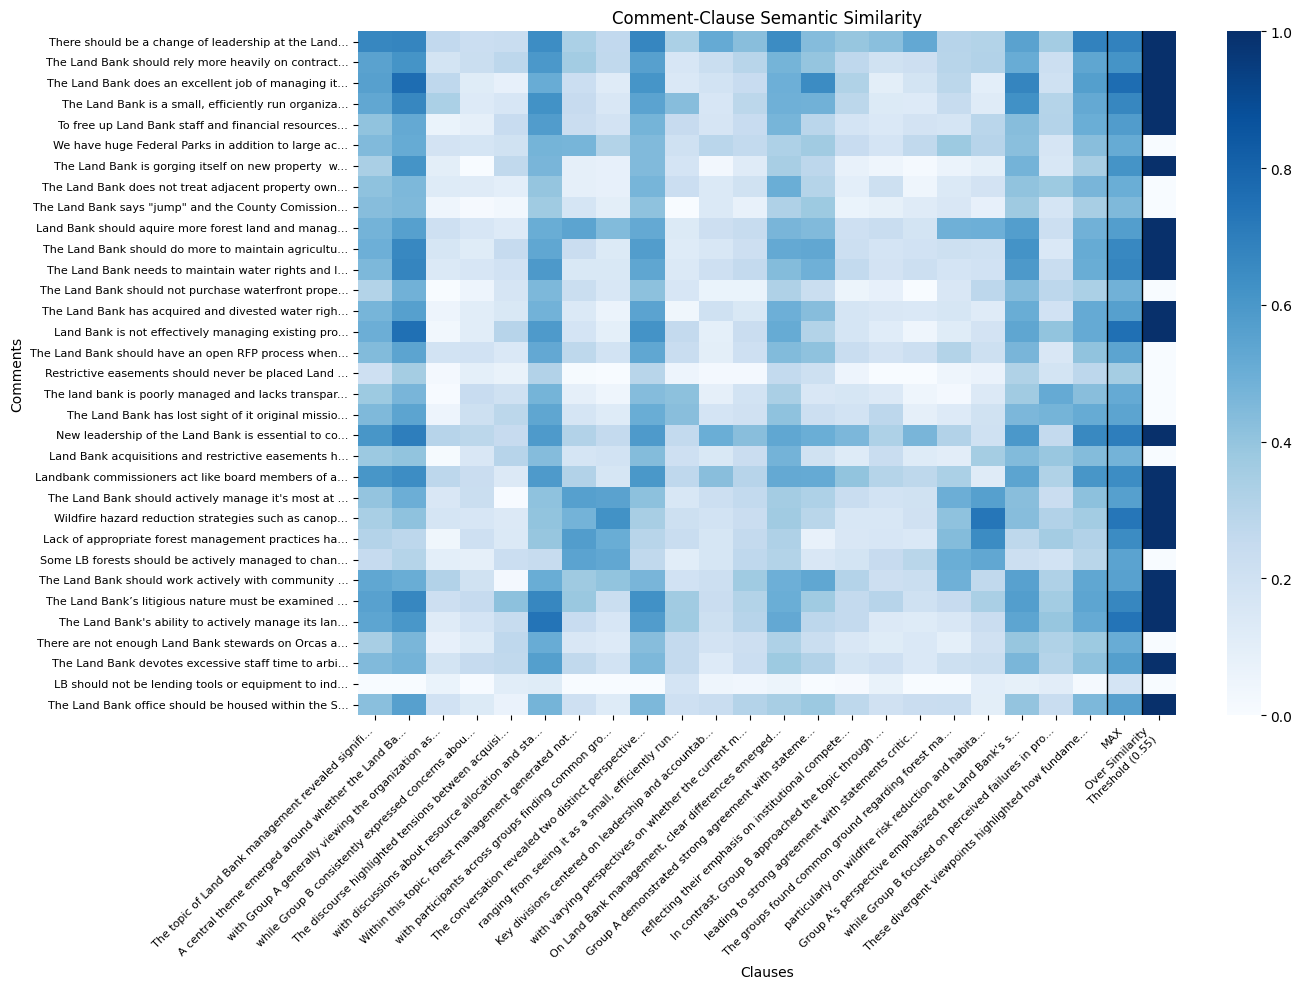

In [15]:
# Usage:
# Define a similarity threshold
threshold = 0.55

# Compute similarity matrix with threshold-based column
similarity_matrix = compute_similarity_matrix(comments, clauses, threshold)

# print stats
thresh = threshold
percentage, count, total = calculate_percentage_above_threshold(similarity_matrix, thresh)
cited_comments = loaded_data['coverageStats']['citedCommentsCount']
print(f"Citation coverage: {100*cited_comments/total:.0f}% ----- {cited_comments} out of {total} COMMENTS were cited in atleast one CLAUSE")
print(f"Sim{100*thresh:.0f} coverage = {percentage:.0f}% ----- {count} out of {total} COMMENTS have a similarity above {thresh} with atleast one CLAUSE")

# Create and display heatmap of COMMENT x CLAUSE similarity
fig, ax = plot_similarity_heatmap(similarity_matrix, comments, clauses, threshold=threshold)
plt.show()

### Compute compression ratio analoges

In [17]:
def sum_text_characters(df):
    """
    Calculate the total number of characters in the 'text' column of a DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing a 'text' column with string values

    Returns:
    int: Total number of characters across all strings in the 'text' column
    """
    # Check if 'text' column exists
    if 'text' not in df.columns:
        raise ValueError("DataFrame does not contain a 'text' column")

    # Filter out non-string values and NaN values
    text_series = df['text'].dropna()

    # Convert any non-string values to strings
    text_series = text_series.astype(str)

    # Calculate the length of each string and sum them
    total_characters = text_series.str.len().sum()

    return int(total_characters)

def calculate_evals(comments, clauses, similarity_matrix,thresh=0.55):
  evals = {}
  evals["comments_length"] = {"value":sum_text_characters(comments),"description":"the total number of characters in all of the the comments"}
  evals["report_length"] = {"value":sum_text_characters(clauses),"description":"the total number of characters in all of the clauses of the report"}
  evals["compression_ratio"] = {"value":sum_text_characters(clauses)/sum_text_characters(comments),"description":"report_length / comments_length"}
  percentage55, count55, ncomments = calculate_percentage_above_threshold(similarity_matrix, thresh)
  evals["total_comments"] = {"value":ncomments,"description":"the total number of comments there were given provided as input to the report"}
  scc_name = f"sim{100*thresh:.0f}_comments_covered"
  evals[scc_name] = {"value":count55,"description":f"the total number of comments that had a semanitic similarity above {thresh} with alteast one clause in the report"}
  sc_name = f"sim{100*thresh:.0f}_coverage"
  evals[sc_name] = {"value":percentage55/100,f"description":f"sim{100*thresh:.0f}_comments_covered / total_comments"}
  sce_name = f"sim{100*thresh:.0f}_compression_efficiency"
  evals[sce_name] = {"value":evals[sc_name]["value"]/evals["compression_ratio"]["value"],"description":f"sim{100*thresh:.0f}_coverage / compression_ratio -- bigger is better!"}
  return evals


In [25]:
evals = calculate_evals(comments, clauses, similarity_matrix)
evals

{'comments_length': {'value': 3382,
  'description': 'the total number of characters in all of the the comments'},
 'report_length': {'value': 2313,
  'description': 'the total number of characters in all of the clauses of the report'},
 'compression_ratio': {'value': 0.6839148432879952,
  'description': 'report_length / comments_length'},
 'total_comments': {'value': 33,
  'description': 'the total number of comments there were given provided as input to the report'},
 'sim55_comments_covered': {'value': 21,
  'description': 'the total number of comments that had a semanitic similarity above 0.55 with alteast one clause in the report'},
 'sim55_coverage': {'value': 0.6363636363636364,
  'description': 'sim55_comments_covered / total_comments'},
 'sim55_compression_efficiency': {'value': 0.9304720355304014,
  'description': 'sim55_coverage / compression_ratio -- bigger is better!'}}

## full eval pipeline

In [19]:
# eg file_id = "1nwboe43hoofvdvTNbFr8PJ_-OVgHlnpn"
def run_eval_pipeline(file_id):
  loaded_data = load_data_from_gdrive(file_id)
  comments, clauses  = extract_to_dataframes(loaded_data)
  comments = embed_df_text(comments)
  clauses = embed_df_text(clauses)
  similarity_matrix = compute_similarity_matrix(comments, clauses, 0.50)
  evals = calculate_evals(comments, clauses, similarity_matrix)
  loaded_data['evals'] = evals
  return loaded_data

In [20]:
# files to grab diff versions from
files = [
    {"name": "groups_openai_3o-mini_2025-03-20T19-18-22-848Z", "gid": "1cvkNMBmcV6WiO13STub7iWE1kzvH2J2A"},
    {"name": "groups_openai_3o-mini_2025-03-20T19-11-17-111Z", "gid": "1CKFOeEFoSNkILkvKSyhPB_eR-4msNjC0"},
    {"name": "groups_openai_o1_2025-03-20T18-51-00-979Z", "gid": "1AEeDdixv5kpQw0TZGnbsIHOf4cr5fSJz"},
    {"name": "groups_openai_o1_2025-03-20T18-50-55-702Z", "gid": "1RhhY5_Bk8fbrjm3WYXZAL_tfqNz1br4r"},
    {"name": "groups_openai_4omini", "gid": "1smOfLp3nKx2rY13OXxB6Mi96nbbsfixM"},
    {"name": "groups_openai_4o", "gid": "1QlJZ6vtjezF9_8ifN258Pld7Gl6FTX4u"}
]

alldata = {}

for file in files:
  alldata[file['name']] = run_eval_pipeline(file['gid'])


Downloading...
From: https://drive.google.com/uc?id=1cvkNMBmcV6WiO13STub7iWE1kzvH2J2A
To: /content/global_inputs.json
100%|██████████| 38.6k/38.6k [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CKFOeEFoSNkILkvKSyhPB_eR-4msNjC0
To: /content/global_inputs.json
100%|██████████| 38.2k/38.2k [00:00<00:00, 37.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AEeDdixv5kpQw0TZGnbsIHOf4cr5fSJz
To: /content/global_inputs.json
100%|██████████| 38.5k/38.5k [00:00<00:00, 36.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RhhY5_Bk8fbrjm3WYXZAL_tfqNz1br4r
To: /content/global_inputs.json
100%|██████████| 38.6k/38.6k [00:00<00:00, 36.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1smOfLp3nKx2rY13OXxB6Mi96nbbsfixM
To: /content/global_inputs.json
100%|██████████| 40.0k/40.0k [00:00<00:00, 43.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QlJZ6vtjezF9_8ifN258Pld7Gl6FTX4u
To: /content/global_inputs.json
100%|██████████| 40.3k/40.3

In [21]:
#just_evals
evals = []
columns = ['name','comments_length','report_length','compression_ratio','total_comments','sim55_comments_covered','sim55_coverage','sim55_compression_efficiency']
for file in files:
  data = alldata[file['name']]
  evals.append([file['name'],
                data['evals']['comments_length']['value'],
                data['evals']['report_length']['value'],
                data['evals']['compression_ratio']['value'],
                data['evals']['total_comments']['value'],
                data['evals']['sim55_comments_covered']['value'],
                data['evals']['sim55_coverage']['value'],
                data['evals']['sim55_compression_efficiency']['value']])
evalsDF = pd.DataFrame(evals, columns=columns)


In [22]:
evalsDF

,name,comments_length,report_length,compression_ratio,total_comments,sim55_comments_covered,sim55_coverage,sim55_compression_efficiency
0,groups_openai_3o-mini_2025-03-20T19-18-22-848Z,1674,1794,1.071685,19,2,0.105263,0.098222
1,groups_openai_3o-mini_2025-03-20T19-11-17-111Z,1674,1830,1.093190,19,3,0.157895,0.144435
2,groups_openai_o1_2025-03-20T18-51-00-979Z,1674,1767,1.055556,19,1,0.052632,0.049861
3,groups_openai_o1_2025-03-20T18-50-55-702Z,1674,1864,1.113501,19,9,0.473684,0.425401
4,groups_openai_4omini,1674,2340,1.397849,19,7,0.368421,0.263563
5,groups_openai_4o,1674,2203,1.316010,19,6,0.315789,0.239960
